# Mad1 inference new objective function 

Set the hyperparameters to $S=3,R=3$.

In [1]:
hypars = [3,3]; # [S,R]
# pf defined for the priors (see SI).
pf = (hypars[1]-1)/2

1.0

Gene number is 3 for mad1endog.

In [2]:
gn = 3;

Import the relevant packages and simulations.

In [3]:
using Random, Plots, LaTeXStrings, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures, Revise, GpABC, JLD2, FileIO

In [4]:
Plots.theme(:dao)
Plots.gr_cbar_width[] = 0.01;

In [5]:
Revise.track("/users/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
include("/users/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
using .SSAnonVD

Define a nice colorblind color scheme.

In [6]:
pal = cgrad(:tol_muted);
cpal = [pal[i] for i in 1/7:1/7:1.0]
population_colors = cpal

Import the data.

In [7]:
df_nuc = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/nuclear-vol-corr.csv"));
df_cyto = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/cyto-vol-corr.csv"));
delete!(df_nuc, 2);
delete!(df_cyto, 2);

In [8]:
gnames = df_cyto[!,"gene"]
Ns = df_nuc[!,"N"];
cyto_means = df_cyto[!,"Mean"];
nuc_FFs = df_nuc[!,"FF"];
cyto_FFs = df_cyto[!,"FF"];

In [9]:
gnames[gn]

"mad1endog"

Define the timescales necessary to predict the steady-state time. `sim_time` defines the point at which the steady state is assumed to be reached.

In [10]:
tdeg = 1;
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [11]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

sim_time (generic function with 1 method)

Import the values from the bootstrapping for the distance function weighting. It is the inverse of these errors that multiples each square error (larger variance in the sample statistic gives it a lesser weighting in the objective function). 

In [12]:
bootstrapping = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/meanCyto_FF_withVar_forJames_230422.csv"))
ro_df = DataFrame([[] for i in 1:length(names(bootstrapping))], names(bootstrapping)) # empty df
for name in gnames
    ind = findfirst(isequal(name), bootstrapping[!,:gene])
    push!(ro_df, bootstrapping[ind,:])
end
# save("./ABC-new/ABC-redo/bootstrapping.jld", "reordered-BS", ro_df)

In [13]:
# bootstrapping=load("./bootstrapping.jld2")["reordered-BS"];

Take the bootstrapped sample variances (can now use the index `gn` defined above).

In [14]:
bs_cyto = bootstrapping[!,"varmeanRNA_Cytoplasm"][gn]
bs_ffn = bootstrapping[!,"varFF_Nucleus"][gn]
bs_ffc = bootstrapping[!,"varFF_Cytoplasm"][gn];
bs_vec = [bs_cyto, bs_ffn, bs_ffc]

3-element Vector{Float64}:
 0.00097597986827156
 0.00046846818921143
 0.00046542617003464

Define the distance function.

In [15]:
function new_distance(traj1::Matrix, traj2::Matrix)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end
function new_distance(traj1::Vector, traj2::Vector)
    return sum([bs_vec[i]^(-1)*((traj1[i]-traj2[i])/traj2[i])^2 for i in 1:length(traj1)])
end

new_distance (generic function with 2 methods)

# Let's do the ABC!

In [16]:
gnames[gn]

"mad1endog"

In [17]:
function simulator_fn_3(pars)
    op = SSA(Ns[gn], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn_3 (generic function with 1 method)

Let's look at the value of the objective function for something close to an optimum value. This informs what our threshold schedule for the ABC will be.

In [18]:
new_distance(simulator_fn_3([2.54,3.64,20.0]),reshape([cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]],(3,1)))

47.31717812559202

In [19]:
# ABC priors
priors_3 = [Uniform(pf*0.5,pf*10.5), Uniform(0.5, 10.5), Uniform(0.5,100.5)]

# number of particles
n_particles = 1000

# ABC hpars
threshold_schedule_3 = [200.0, 100.0, 50.0, 25.0, 20.0, 10.0, 5.0]

7-element Vector{Float64}:
 200.0
 100.0
  50.0
  25.0
  20.0
  10.0
   5.0

In [20]:
sim_abcsmc_res_3 = SimulatedABCSMC(reshape([cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]],(3,1)),
    simulator_fn_3,
    priors_3,
    threshold_schedule_3,
    n_particles; 
    max_iter=convert(Int, 1e5),
    distance_function = new_distance,
    write_progress=true);

[ Info: GpABC rejection simulation. ϵ = 200.0.
[ Info: GpABC rejection simulation. Accepted 235/1000 particles.
[ Info: GpABC rejection simulation. Accepted 474/2000 particles.
[ Info: GpABC rejection simulation. Accepted 737/3000 particles.
[ Info: GpABC rejection simulation. Accepted 979/4000 particles.
[ Info: GpABC SMC simulation ϵ = 100.0
[ Info: GpABC SMC simulation accepted 245/1000 particles.
[ Info: GpABC SMC simulation accepted 493/2000 particles.
[ Info: GpABC SMC simulation accepted 768/3000 particles.
[ Info: GpABC SMC simulation ϵ = 50.0
[ Info: GpABC SMC simulation accepted 170/1000 particles.
[ Info: GpABC SMC simulation accepted 350/2000 particles.
[ Info: GpABC SMC simulation accepted 546/3000 particles.
[ Info: GpABC SMC simulation accepted 724/4000 particles.
[ Info: GpABC SMC simulation accepted 882/5000 particles.
[ Info: GpABC SMC simulation ϵ = 25.0
[ Info: GpABC SMC simulation accepted 134/1000 particles.
[ Info: GpABC SMC simulation accepted 280/2000 particles

[ Info: GpABC SMC simulation accepted 912/35000 particles.
[ Info: GpABC SMC simulation accepted 941/36000 particles.
[ Info: GpABC SMC simulation accepted 974/37000 particles.


Quick look at the results...

In [21]:
plot(sim_abcsmc_res_3, population_colors=population_colors)

Save these results using the JLD package.

In [43]:
save("./S3R3allGenes/S$(hypars[1])R$(hypars[2])_$(gnames[gn]).jld2", "ABC", sim_abcsmc_res_3)

Let's collect the important aspects of this ABC for analysis. We want:
- 1. The parameter values of the accepted particles.
- 2. The acceptance rate for the final threshold.

Note the different field names are: `n_accepted`, `n_tries`, `threshold_schedule`, `population`, `distances`, `weights`.

In [23]:
acc_rate = sim_abcsmc_res_3.n_accepted[end]/sim_abcsmc_res_3.n_tries[end]

0.026398458330033524

So the acceptance rate at the final threshold was around 0.2. Let's now look at the mean and standard deviations of the predicted values of $k_A$, $k_B$ and $k_C$ from the population.

In [24]:
pop = sim_abcsmc_res_3.population[end];

In [25]:
kA = pop[:,1]; kB = pop[:,2]; kC = pop[:,3];

In [26]:
kAmed = median(kA)

2.9370024925007687

In [27]:
kAstd = std(kA)

0.4442415062175909

In [28]:
kBmed = median(kB)

1.827402737898879

In [29]:
kBstd = std(kB)

0.389611887260471

In [30]:
kCmed = median(kC)

14.284300705584142

In [31]:
kCstd = std(kC)

6.312757271423456

Let's make some nice plots of these (the three histograms followed by the joint uncertainty plots as a 2D hist).

In [32]:
h1 = stephist(kA, fill = true, fillalpha = 0.5, color = cpal[1], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_A", title = "(a)", ylims = [0,3.5])
plot!([kAmed,kAmed],[0,100], style = :dash, color = :black, label = L"$k_C$ median");

In [33]:
h2 = stephist(kB, fill = true, fillalpha = 0.5, color = cpal[2], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_B", title = "(b)", ylims = [0,0.3])
plot!([kBmed,kBmed],[0,1.2], style = :dash, color = :black, label = L"$k_B$ median");

In [34]:
h3 = stephist(kC, fill = true, fillalpha = 0.5, color = cpal[3], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_C", 
        title = "(c)", ylims = [0,0.025])
plot!([kCmed,kCmed],[0,2], style = :dash, color = :black, label = L"$k_C$ median");

In [35]:
c1 = plot(h1, h2, h3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm);

In [36]:
p1 = histogram2d(kA, kB, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA):(maximum(kA)-minimum(kA))/15:maximum(kA)), collect(minimum(kB):(maximum(kB)-minimum(kB))/15:maximum(kB))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_B", title = "(d)");

In [37]:
p2 = histogram2d(kA, kC, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA):(maximum(kA)-minimum(kA))/15:maximum(kA)), collect(minimum(kC):(maximum(kC)-minimum(kC))/15:maximum(kC))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_C", title = "(e)");

In [38]:
p3 = histogram2d(kB, kC, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kB):(maximum(kB)-minimum(kB))/15:maximum(kB)), collect(minimum(kC):(maximum(kC)-minimum(kC))/15:maximum(kC))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_B", ylabel = L"k_C", title = "(f)");

In [39]:
c2 = plot(p1, p2, p3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm, left_margin = 5.0mm, right_margin = -10mm);

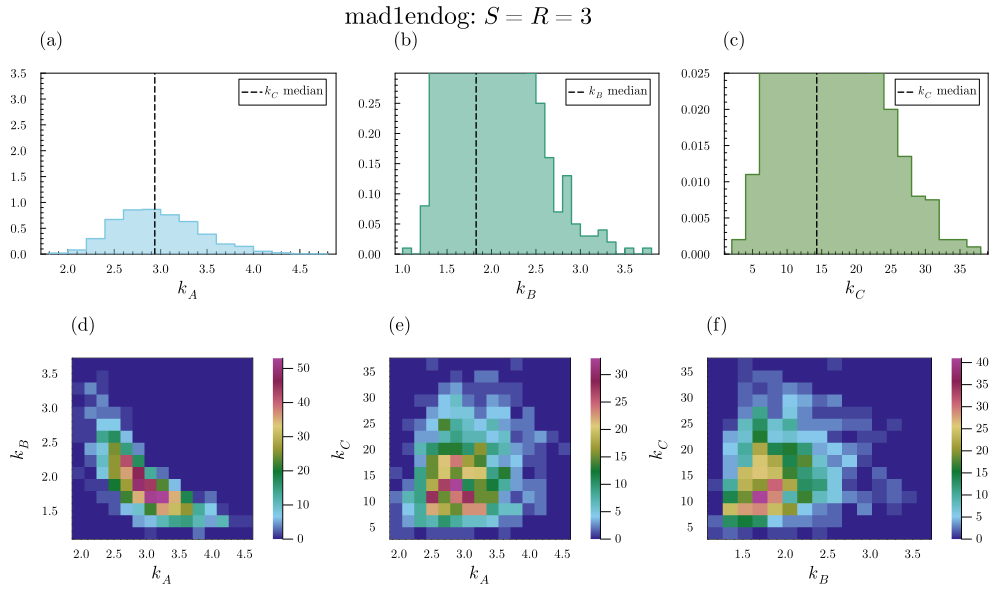

In [40]:
plot(c1,c2, layout = (2,1), size = (1000,600), plot_title=L"%$(gnames[gn]): $S=R=3$")
# savefig("./S3R3allGenes/S$(hypars[1])R$(hypars[2])_$(gnames[gn]).pdf")

Check if the moments replicate those from the original data.

In [41]:
[cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]]

3-element Vector{Float64}:
 1.74181548708104
 0.92893586062368
 0.619817985303977

In [42]:
mean([simulator_fn_3([kAmed,kBmed,kCmed]) for i in 1:100])

3×1 Matrix{Float64}:
 1.7442257597684512
 0.9469082867304354
 0.6342762244890038

So, pretty good overall.